In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
from scipy.spatial import distance_matrix
%matplotlib inline

import MDAnalysis as mda
from MDAnalysis.analysis import align
#from MDAnalysis.analysis.rms import rmsd

# Functions

In [18]:
def aligment_rotation(reference, not_reference):
    
    ref = mda.Universe(reference)
    mobile = mda.Universe(not_reference)
    
    ref0 = ref.select_atoms('name CA').positions - ref.atoms.center_of_mass()
    mobile0 = mobile.select_atoms('name CA').positions - mobile.atoms.center_of_mass()
    mobile_all = mobile0
    #mobile_all = mobile.select_atoms('all').positions - mobile.atoms.center_of_mass()
    
    Ra, rmsd = align.rotation_matrix(mobile0, ref0)
    mobile_rotated=np.dot(Ra, mobile_all.T)
    
    return (Ra, mobile_rotated)

def aligment_rotation_coord(reference, not_reference):
    
    Ra, mobile_rotated = aligment_rotation(reference, not_reference)
    
    mobile_rot_x=mobile_rotated[0]
    mobile_rot_y=mobile_rotated[1]
    mobile_rot_z=mobile_rotated[2]
    
    return (mobile_rot_x, mobile_rot_y, mobile_rot_z)

def quaternion_rotation(q, x, y, z):
    
    Q = R.from_quat(q).as_matrix()
    
    coord = np.array([x,y,z])
    rot_coord = np.dot(Q, coord)
    
    x_rot = rot_coord[0]
    y_rot = rot_coord[1]
    z_rot = rot_coord[2]
    
    return(x_rot, y_rot, z_rot)

def calc_img(coord, params):

    pixel_size = params[0]
    n_pixels = params[1]
    sigma = params[2]
    n_atoms = coord.shape[1]
    norm =  (2 * np.pi * sigma**2 * n_atoms)

    grid_min = -pixel_size * (n_pixels - 1)*0.5
    grid_max = pixel_size * (n_pixels - 1)*0.5 + pixel_size

    x_grid = np.arange(grid_min, grid_max, pixel_size)
    y_grid = np.arange(grid_min, grid_max, pixel_size)

    gauss = np.exp( -0.5 * ( ((x_grid[:,None] - coord[0,:])/sigma)**2) )[:,None] * \
            np.exp( -0.5 * ( ((y_grid[:,None] - coord[1,:])/sigma)**2) )

    Icalc = gauss.sum(axis=2)

    return Icalc/norm

def grad_2corr(coord, Ic, Ir, params):

    pixel_size, n_pixels, sigma = params[0], params[1], params[2]
    n_atoms = coord.shape[1]
    norm =  (2 * np.pi * sigma**2 * n_atoms)
    
    grid_min = -pixel_size * (n_pixels - 1)*0.5
    grid_max = pixel_size * (n_pixels - 1)*0.5 + pixel_size

    x_grid = np.arange(grid_min, grid_max, pixel_size)
    y_grid = np.arange(grid_min, grid_max, pixel_size)

    grad = np.zeros_like(coord)

    # CV
    s = np.sum(Ic * Ir)
    gcr = -s  / ( np.sum(Ic) * np.sum(Ir) )

    # Grid with gaussians for every atom
    f1 = np.exp( -0.5 * ( ((x_grid[:,None] - coord[0,:])/sigma)**2) )[:,None] * \
         np.exp( -0.5 * ( ((y_grid[:,None] - coord[1,:])/sigma)**2) )

    fx = (x_grid[:,None] - coord[0,:])[:, None] / sigma**2
    fy = (y_grid[:,None] - coord[1,:])[:, None] / sigma**2

    grad[0, :] = np.sum( ((fx*f1).T * Ir.T).T, axis=((0), (1)) )/s -\
                 np.sum(fx * f1, axis=((0), (1)))/np.sum(Ic)

    grad[1, :] = np.sum( ((fy*f1).T * Ir.T).T, axis=((0), (1)) )/s -\
                 np.sum( fy * f1, axis=((0), (1)))/np.sum(Ic)
    
    grad *= gcr / norm

    return gcr, grad

def grad_harmonic(coord, params):
    d0 = params[3]
    x_atom, y_atom = coord[0], coord[1]
    
    grad_x=np.zeros_like(x_atom)
    grad_y=np.zeros_like(y_atom)
    
    D=np.sqrt((x_atom[1:]-x_atom[:-1])**2 +(y_atom[1:]-y_atom[:-1])**2)
    
    grad_x[1:-1]=2*((1-d0/D[1:])*(x_atom[1:-1]-x_atom[2:]) - (1-d0/D[:-1])*(x_atom[:-2]-x_atom[1:-1]))
    grad_x[0]=2 * ((1 - d0/D[0]) * (x_atom[0] - x_atom[1]))
    grad_x[-1]=2 * ( (1 - d0/D[-1]) * (x_atom[-2] - x_atom[-1]) )
    
    grad_y[1:-1]=2*((1-d0/D[1:])*(y_atom[1:-1]-y_atom[2:]) - (1-d0/D[:-1])*(y_atom[:-2]-y_atom[1:-1]))
    grad_y[0]=2 * ((1 - d0/D[0]) * (y_atom[0] - y_atom[1]))
    grad_y[-1]=2 * ( (1 - d0/D[-1]) * (y_atom[-2] - y_atom[-1]) )
    
    grad_D=np.array([grad_x, grad_y])
    return(grad_D)

def grad_total(coord, Ic, Ir, params):
    w = params[4]
    return grad_2corr(coord, Ic, Ir, params)[1] + w*grad_harmonic(coord, params)

def nested_anh_gradiend_descent_total(Ir, coord_c, params_c, params_gd):
    
    sigmaf, k, N, N_int = params_gd
    params_gd=params_c
    sigma0=params_c[2]
    coord_gd=coord_c
    
    Ic=calc_img(coord_c, params_c)
    grad = grad_total(coord_c, Ic, Ir, params_c)
    
    for i in tqdm(range(int(N))):
        sigma =-((sigma0-sigmaf)/(N-1))*i + sigma0
        params_gd[2]=sigma
        
        for j in range(int(N_int)):
            
            coord_gd = coord_gd - k*grad
            Ic_gd = calc_img(coord_gd, params_gd)
            grad = grad_total(coord_gd, Ic_gd, Ir, params_gd)
            
    # CV
    s = np.sum(Ic_gd * Ir)
    gcr = -s  / ( np.sum(Ic_gd) * np.sum(Ir) )
    
    return (gcr, grad, Ic_gd, coord_gd)

# Aligment, Rotation and Projection

## Real Image

In [19]:
reference='groel_frame_13120.pdb'
not_reference='groel_apo.pdb'

q=[0,0,1/np.sqrt(2),1/np.sqrt(2)] #Quaternion parameters

n=3      #Sigma times
sigma=1  #Standar deviation of the Gaussians
res=128  #Grid's resolution

x_r, y_r, z_r = aligment_rotation_coord(reference, not_reference)

x_r, y_r, z_r = quaternion_rotation(q, x_r, y_r, z_r)

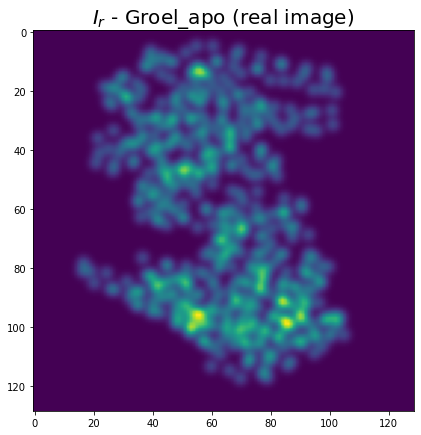

In [20]:
pixel_size, n_pixels, sigma, d0, w = 0.6, 128, 1, 3, 1e-6
coord_r=np.array([x_r, y_r])
params=np.array([pixel_size, n_pixels, sigma, d0, w])

Ir=calc_img(coord_r, params)
plt.imshow(Ir)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_r$ - Groel_apo (real image) ', fontsize=20)
plt.show()

## Calculated Image

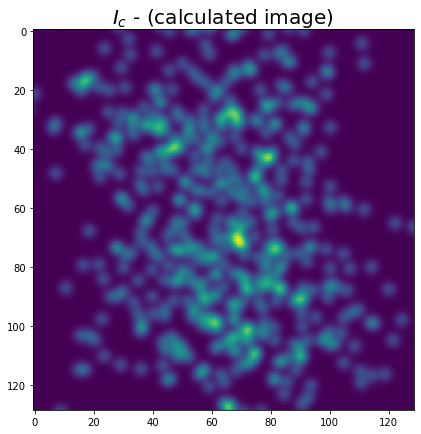

In [37]:
g=10

x_noise=np.random.normal(0, g, x_r.shape)
y_noise=np.random.normal(0, g, y_r.shape)

x_c=x_r+x_noise
y_c=y_r+y_noise

coord_c=np.array([x_c, y_c])

Ic=calc_img(coord_c, params)
plt.imshow(Ic)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_c$ - (calculated image) ', fontsize=20)
plt.show()

## CV: Second Order Correlation Function

In [49]:
g2, g2_grad=grad_2corr(coord_c, Ic, Ir, params)
print('CV: g2 = ', g2)
print('Grad CV =', g2_grad)


CV: g2 =  -0.0001102155147773293
Grad CV = [[-2.77491621e-10  8.34215859e-08  1.19330540e-08 ... -2.99440944e-08
   6.98616254e-08 -1.08828548e-49]
 [ 6.11166338e-06  5.04782654e-06 -4.57594388e-06 ...  5.90691927e-06
  -3.57956551e-06  3.75323594e-31]]


## Total Gradient (Adding the Hamonic Potential)

In [39]:
grad_total(coord_c, Ic, Ir, params)

array([[-1.38764019e-05,  6.01869175e-06,  9.22052602e-06, ...,
        -1.86830747e-05,  8.05040571e-06, -6.46826351e-06],
       [ 8.18565555e-06, -3.43136546e-05,  3.13021956e-05, ...,
        -4.94786894e-05,  1.34749452e-04,  9.77686611e-05]])

# Nested Gradient Descent with Anh

In [40]:
sigma0 = 100
params_c=params
params_c[2]=sigma0

sigmaf, k, N, N_int = sigma, 10e3, 20, 20
params_gd=np.array([sigmaf, k, N, N_int])

gcr, grad, Ic_gd, coord_gd = nested_anh_gradiend_descent_total(Ir, coord_c, params_c, params_gd)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.52s/it]


## Final Calculated Image with GD Method

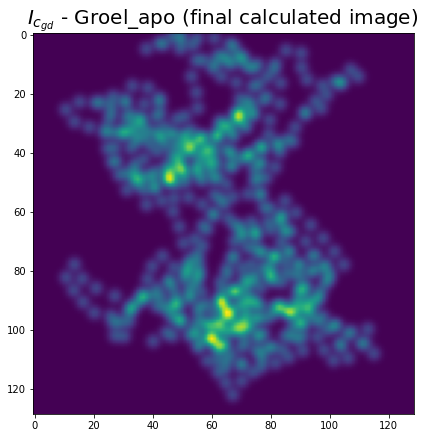

In [53]:
plt.imshow(Ic_gd)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_{c_{gd}}$ - Groel_apo (final calculated image) ', fontsize=20)
plt.show()

# Coordinates Graphs

In [42]:
r_r=np.array([[x_r[i], y_r[i]] for i in range(len(x_r))])
r_c=np.array([[x_c[i], y_c[i]] for i in range(len(x_c))])
r_gd_f=np.array([[coord_gd[0][i], coord_gd[1][i]] for i in range(len(coord_gd[0]))])

RR=np.array([[np.cos(-np.pi/2), -np.sin(-np.pi/2)],[np.sin(-np.pi/2), np.cos(-np.pi/2)]])

Text(0.5, 1.0, 'Coordinates of $I_r$ (black) and initial $I_c$ (red)')

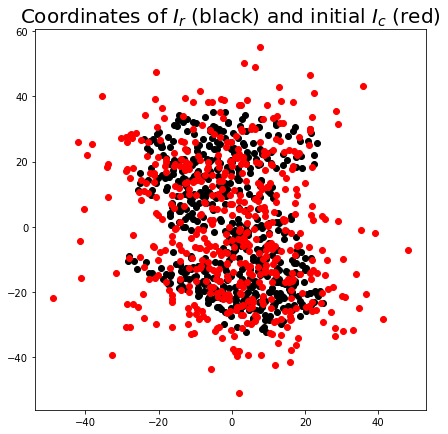

In [43]:
plt.rcParams["figure.figsize"] = (7,7)
plt.scatter(np.dot(RR,r_r.T)[0],np.dot(RR,r_r.T)[1], color='black')
plt.scatter(np.dot(RR,r_c.T)[0], np.dot(RR,r_c.T)[1], color='red')
plt.title(r'Coordinates of $I_r$ (black) and initial $I_c$ (red)', fontsize=20)

Text(0.5, 1.0, 'Coordinates of $I_r$ (black) and final $I_c$ (red)')

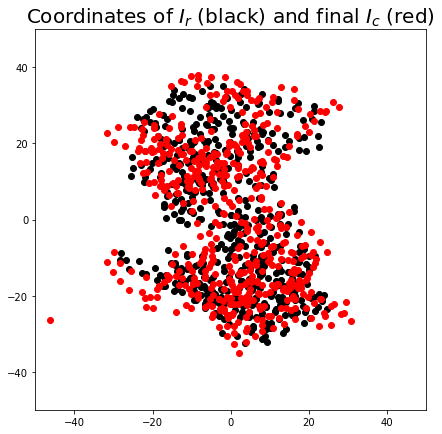

In [44]:
plt.rcParams["figure.figsize"] = (7,7)
plt.scatter(np.dot(RR,r_r.T)[0],np.dot(RR,r_r.T)[1], color='black')
plt.scatter(np.dot(RR,r_gd_f.T)[0], np.dot(RR,r_gd_f.T)[1], color='red')
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.title(r'Coordinates of $I_r$ (black) and final $I_c$ (red)', fontsize=20)